# 평가 조건
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
    - 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.
2. Transformer 번역기 모델이 정상적으로 구동된다.
    - Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.

# 모듈 임포트

In [1]:
import tensorflow as tf

import sentencepiece as spm

from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import time
import re
import os
import io

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 데이터 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'

kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 전처리

## 1. 중복 제거 함수

In [3]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
        
    raw_data = pd.DataFrame({'korea':kor, 'english':eng})
    
    raw_data.drop_duplicates(inplace = True)
    raw_data = raw_data[~raw_data.duplicated(subset='korea')]
    raw_data = raw_data[~raw_data.duplicated(subset='english')]
    
    raw_data = raw_data.reset_index(drop=True)
    
    print('전체 중복:',sum(raw_data.duplicated()))
    print('한국어 중복',sum(raw_data.duplicated(subset='korea')))
    print('영어 중복',sum(raw_data.duplicated(subset='english')))
    print('-----'*5)
    print('중복을 제외한 데이터의 수',len(raw_data))
    
    return raw_data

## 2. 단어 정제 함수

In [4]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r'\([^)]*\)', r'', sentence) #괄호로 둘러싸인 부분 제거
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence) #문장 내의 구둣점과 숫자 양 옆에 공백 추가
    sentence = re.sub(r'[^a-zA-Z가-힣0-9?.!, ]+', r' ', sentence) #영문 알파벳, 한글, 숫자, 구둣점을 제외한 모든 문자를 제거
    sentence = re.sub(r"['\n']+", r"", sentence) #개행 문자 제거
    sentence = re.sub(r'["   "]+', " ", sentence) #연속된 공백을 하나의 공백으로 변환

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

## 3. sentencepiece 토크나이저 생성

In [5]:
ko_temp_file = os.getenv('HOME') + '/aiffel/going_deeper/ko_spm.temp'
en_temp_file = os.getenv('HOME') + '/aiffel/going_deeper/en_spm.temp'

def generate_tokenizer(corpus,
                        model_name,
                        vocab_size,
                        temp_file,
                        lang=None,
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
            
    spm.SentencePieceTrainer.Train(
        '--input={} \
        --model_prefix={} \
        --vocab_size={} \
        --accept_language={}\
        --pad_id={} \
        --bos_id={} \
        --eos_id={} \
        --unk_id={}'.format(temp_file, model_name, vocab_size+4, lang, pad_id, bos_id, eos_id, unk_id)
)
    
    s = spm.SentencePieceProcessor()
    s.Load('{}.model'.format(model_name))     

    return s

In [11]:
def sp_tokenize(model_name, corpus):
    
    s = spm.SentencePieceProcessor()
    s.Load('{}.model'.format(model_name))
    
    corpus_list = []

    for sen in tqdm(corpus):
        corpus_list.append(s.EncodeAsIds(sen))
        
    with open("./{}.vocab".format(model_name), 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})


    return corpus_list, word_index, index_word

## 4. 길이 확인

In [7]:
def data_lens(data, name):
    
    print('{} 데이터의 최소 길이 :{}'.format(name, min(len(l) for l in data)))
    print('{} 데이터의 최대 길이 :{}'.format(name, max(len(l) for l in data)))
    print('{} 데이터의 평균 길이 :{}'.format(name, sum(map(len, data))/len(data)))

    plt.hist([len(s) for s in data], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

In [8]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

-----------------------------------------------------------------

In [9]:
raw_data = clean_corpus(kor_path, eng_path)

전체 중복: 0
한국어 중복 0
영어 중복 0
-------------------------
중복을 제외한 데이터의 수 74849


In [10]:
kor_corpus = []
eng_corpus = []

for sentence in tqdm(raw_data['korea']):
    kor_corpus.append(preprocess_sentence(sentence))
    
for sentence in tqdm(raw_data['english']):
    eng_corpus.append(preprocess_sentence(sentence, s_token=True, e_token=True))

print("한국어:", kor_corpus[33])   
print("영어:", eng_corpus[33])

100%|██████████| 74849/74849 [00:01<00:00, 38833.59it/s]

한국어: 로보트 장치의 연간 판매액은 5 0 억 6 0 억달러로 추산되고 있다 . 
영어: <start> annual sales of robot units are estimated at 5 billion to 6 billion .  <end>


In [12]:
kor_sentencepiece = generate_tokenizer(kor_corpus, 'korea_spm', 25000, ko_temp_file, lang="ko")
eng_sentencepiece = generate_tokenizer(eng_corpus, 'english_spm', 25000, en_temp_file, lang="en")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/going_deeper/ko_spm.temp         --model_prefix=korea_spm         --vocab_size=25004         --accept_language=ko        --pad_id=0         --bos_id=1         --eos_id=2         --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/going_deeper/ko_spm.temp
  input_format: 
  model_prefix: korea_spm
  model_type: UNIGRAM
  vocab_size: 25004
  accept_language: ko
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_scor

In [13]:
eng_sentencepiece.set_encode_extra_options("bos:eos")

True

In [15]:
korea_corpus_list, ko_word_index, ko_index_word = sp_tokenize('korea_spm', kor_corpus)
english_corpus_list, en_word_index, en_index_word = sp_tokenize('english_spm', eng_corpus)

100%|██████████| 74849/74849 [00:03<00:00, 23116.96it/s]


In [16]:
korea_corpus_list[0]

[966, 421, 501, 568, 7, 1228, 1685, 8, 1080, 220, 2616, 915, 36, 10122, 410]

한국어 데이터의 최소 길이 :0
한국어 데이터의 최대 길이 :132
한국어 데이터의 평균 길이 :26.47021336290398


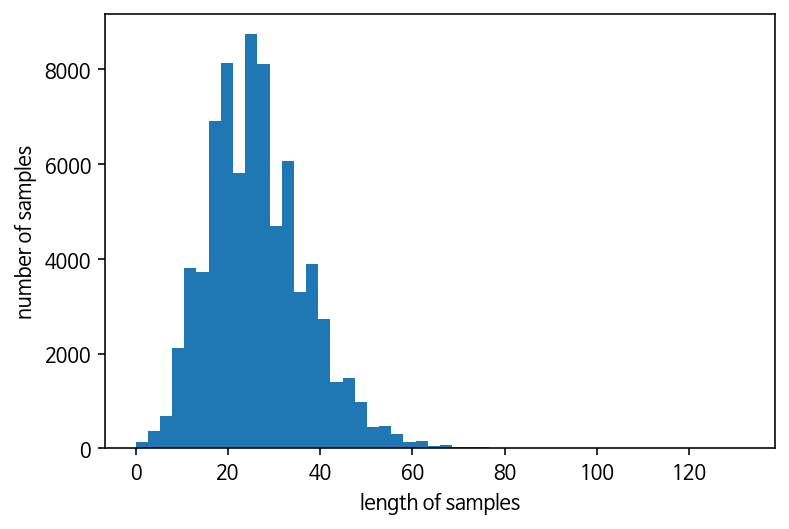

In [18]:
data_lens(korea_corpus_list, '한국어')

영어 데이터의 최소 길이 :6
영어 데이터의 최대 길이 :142
영어 데이터의 평균 길이 :41.61604029445951


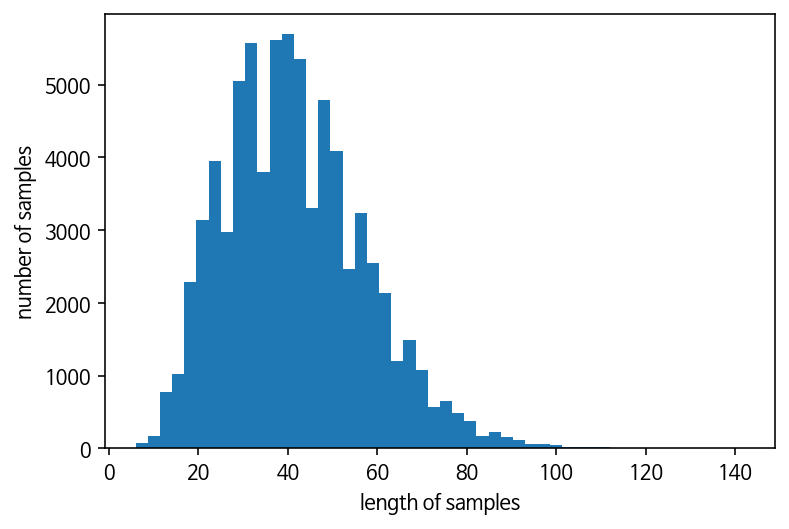

In [19]:
data_lens(english_corpus_list, '영어')

In [20]:
max_len = 50
below_threshold_len(max_len, korea_corpus_list)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 97.6151985998477


In [21]:
max_len = 50
below_threshold_len(max_len, english_corpus_list)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 73.56544509612687


In [22]:
kor_data = tf.keras.preprocessing.sequence.pad_sequences(korea_corpus_list, padding='post', maxlen= max_len)
eng_data = tf.keras.preprocessing.sequence.pad_sequences(english_corpus_list, padding='post', maxlen= max_len)

In [24]:
print(kor_data.shape)
print(eng_data.shape)

(74849, 50)
(74849, 50)


# 모델 설계

### positional_encoding

In [25]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

### MultiHeadAttention

In [45]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        QK = tf.matmul(Q,K, transpose_b = True)
        
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9) 

        attentions = tf.nn.softmax(scaled_qk, axis = -1)
        out = tf.matmul(attentions, V)
        
        
        return out, attentions
        

    def split_heads(self, x):

        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0,2,1,3])
        
        
        return split_x

    def combine_heads(self, x):
        
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
      
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

### PoswiseFeedForwardNet

In [27]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### Encoder & Decoder

In [28]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [30]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [31]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer

In [32]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))


    def embedding(self, emb, x):

        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)


        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)


        return logits, enc_attns, dec_attns, dec_enc_attns

In [33]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### 학습 옵티마이저

In [34]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [35]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [36]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 학습 함수

In [53]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 학습 시각화 함수

In [52]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()
        
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=kor_data.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(eng_data.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

# 모델 훈련

In [54]:
num_layers = 4
d_model = 256
num_heads = 4
d_ff = 1024
pos_len = max_len
vocab_size = 25000
drop_rate = 0.2


examples = [
    "오바마는 대통령이다.", "시민들은 도시 속에 산다.",
    "커피는 필요 없다.", "일곱 명의 사망자가 발생했다.",
    "가족을 사랑한다.","오늘 날씨는 덥다."]

transformer = Transformer(num_layers,
                    d_model,
                    num_heads,
                    d_ff,
                    vocab_size,
                    vocab_size,
                    pos_len,
                    dropout = drop_rate)

In [55]:
BATCH_SIZE = 64
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_data.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
                    train_step(kor_data[idx:idx+BATCH_SIZE],
                                eng_data[idx:idx+BATCH_SIZE],
                                transformer,
                                optimizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    if (epoch+1) % 5 == 0:
        for example in examples:
            translate(example, transformer, kor_sentencepiece, eng_sentencepiece, plot_attention=False)

Epoch  5: 100%|██████████| 1170/1170 [02:46<00:00,  7.01it/s, Loss 2.2388]


Input: 오바마는 대통령이다.
Predicted translation: marks the first time , the president is the president slated to be president , obama s president , the illinois senator said . obama is the president s becoming president , he wrote . <end> <end
Input: 시민들은 도시 속에 산다.
Predicted translation: city , and the city s largest city , the city s largest city , the city s largest city , has a largest city , the city s largest city in the city . <end> <
Input: 커피는 필요 없다.
Predicted translation: coffee , no one of coffee , you don t have any coffee , coffee , don t be coffee , coffee , coffee , or coffee , don t be coffee , coffee said . <end> <
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was killed in the seven death of 2 0 people , wounded , and wounded , killing at least seven people , wounding  ⁇  , 2 0 0  ⁇  <end> <
Input: 가족을 사랑한다.
Predicted translation: love , 2 0 0 9 . . . . . . . . . . . . . . . . . <end> <end
Input: 오늘 날씨는 덥다.
Predicted translation: today , the weather is about today . . . . . 

Epoch 10: 100%|██████████| 1170/1170 [02:47<00:00,  7.01it/s, Loss 1.2788]


Input: 오바마는 대통령이다.
Predicted translation: , obama is a presidential candidate . obama . president obama . president obama is similar to obama , obama said similar to obama . president obama . according to cnn s kyung lah . <end> <end>
Input: 시민들은 도시 속에 산다.
Predicted translation: s , street storms around the city of street . . . . . . . . s . . . s becoming a big stretch of your city . <end> <
Input: 커피는 필요 없다.
Predicted translation: s at work . don t be coffee . <end> . <end> . <end> <end> . <end> <end> <end> <end> <end> <end> <end>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ed at the seven deaths of  ⁇  , injured 8  ⁇  others , injuring seven others , injuring seven others , injuring seven others have died in seven . <end> <
Input: 가족을 사랑한다.
Predicted translation: , a family person in the world , i have been brains with love you . a love brain , i and i d have a love you , d . c . . <end> <
Input: 오늘 날씨는 덥다.
Predicted translation: s today s weather forecast , but weather is weathe

Epoch 15: 100%|██████████| 1170/1170 [02:47<00:00,  7.00it/s, Loss 0.7200]


Input: 오바마는 대통령이다.
Predicted translation: is the first time , obama said tuesday at a cnn conference . obama is the president s word of presidential nominee , which is obama s word that would be president obama s president , obama said tuesday . <end> <
Input: 시민들은 도시 속에 산다.
Predicted translation: deaths on a mountainous city where citizens can grow into the city s main city , are busy amid global sleep , such a city where they slew in a mountain turned city city city . <end> <
Input: 커피는 필요 없다.
Predicted translation: s at work . at the company , don t be rather than work . don t be , at work , depp says at work . otherwise , your work else <end> <end>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: was killed in the seventh of seven others . at least  ⁇  0 people , injuring , others said , among others members of the ⁇  , no officials . <end> <
Input: 가족을 사랑한다.
Predicted translation: daniel cuba s family and daniele a family finish on job together , a family awaits a love daniele deal 

Epoch 20: 100%|██████████| 1170/1170 [02:47<00:00,  7.00it/s, Loss 0.4567]


Input: 오바마는 대통령이다.
Predicted translation: was the first president . obama . obama . cnn . obama . obama . president obama . according to obama , obama s words , where obama is president obama s presidential visit . <end>
Input: 시민들은 도시 속에 산다.
Predicted translation: deaths there s a turn in . . . . . citizens can be in the city but managednight , ap network ho da turned up there to the city s mountainous urban don . <end>
Input: 커피는 필요 없다.
Predicted translation: no coffee for you need a coffee isn t necessary . you need no donations . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ed at seven other lives , seven other dead were injured in seven deaths , but seven others were killed in the blast shook cause care sector in the seven deaths seven others seven people . <end> <
Input: 가족을 사랑한다.
Predicted translation: daniel de love daniel de love daniel , a family and day , i have the family and our family and our family and our fam

Epoch 25: 100%|██████████| 1170/1170 [02:46<00:00,  7.01it/s, Loss 0.3314]


Input: 오바마는 대통령이다.
Predicted translation: was the first foreign . obama . obama . . . . page , obama said tuesday . obama . obama is the presidential candidate and obama will be presidential candidate . <end> <end>
Input: 시민들은 도시 속에 산다.
Predicted translation: s legislature , turn yong in town , 1 8 .  ⁇  billion people turned into a big city but standing to sleep up in town city but people they know the city s maine . <end> <
Input: 커피는 필요 없다.
Predicted translation: is not a coffee for . no matter who don t need coffee . at the cup of coffee requires coffee . at other don t be coffee , at the 6 0 put in reasons . <end> <
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ed at seven others , four others were killed in seven others , while seven others were killed in seven others , killing nearly seven others , the officials . <end> ⁇ 
Input: 가족을 사랑한다.
Predicted translation: s 2 0 th front at our world , and 3 0 days . our family s finally killing 3 . maren in front of our family s finally 

Epoch 30: 100%|██████████| 1170/1170 [02:47<00:00,  7.00it/s, Loss 0.2605]


Input: 오바마는 대통령이다.
Predicted translation: was the only foreign . obama . obama . everyone will be president taking president . obama s words carried president , obama s leading presidential nominating contests , obama . <end>
Input: 시민들은 도시 속에 산다.
Predicted translation: mountains and pat entertainment is a big turn in a city where citizens can be blew into a main city in the city to the city s san . <end> here 8 fearful water breaking . <end> <end
Input: 커피는 필요 없다.
Predicted translation: is no medical needed , there is no motion than a coffee for our works . there isn t a work chair for coffee at coffee lists , that don t you have coffee for your health information . <end> <
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ed at seven lives in seven other countries , leaving among them members of the fighting . but killing seven others were malve involvement , killing at all behind no injuries , the state <end> state
Input: 가족을 사랑한다.
Predicted translation: runs . i loved our loved one pe

# 결과 비교

| Input            | Transformer+sentencepiece                                                                                                                                                                                 | Seq2Seq+Mecab |
| ---------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------- |
| 오바마는 대통령이다.      | was the only foreign . obama . obama . everyone will be president taking president . obama s words carried president , obama s leading presidential nominating contests , obama . <end>               | obama is the president . <end> |
| 시민들은 도시 속에 산다.   | mountains and pat entertainment is a big turn in a city where citizens can be blew into a main city in the city to the city s san . <end> here 8 fearful water breaking . <end> <end                  | civilians are in cities , hurled high of the city . <end> |
| 커피는 필요 없다.       | is no medical needed , there is no motion than a coffee for our works . there isn t a work chair for coffee at coffee lists , that don t you have coffee for your health information . <end> <        | there s no idea of the right now . <end> |
| 일곱 명의 사망자가 발생했다. | ed at seven lives in seven other countries , leaving among them members of the fighting . but killing seven others were malve involvement , killing at all behind no injuries , the state <end> state | seven dead was killed . <end> |
| 가족을 사랑한다.        | runs . i loved our loved one person , cnn days . i loved our guy s loved , our iran s finally killing 2 3 days in love final . <end> <                                                                | family love love of family . <end> |
| 오늘 날씨는 덥다.       | ed today s weather when weather is headed today , the weather is headed today , he s heading up today , sandra s john jay de s john hurt in retail hearing . <end> <                                  | today weather has forced to today <end> |

    
앞 선 노드의 결과와 비교하였을때, Seq2Seq+Mecab으로 했을때 오히려 번역의 품질이 더 좋았습니다.

sentencepiece의 경우 한국어를 제대로 토큰화하지 못한것으로 생각됩니다.

추가적으로 Transformer+Mecab을 시도해보고자 합니다.

# 추가시도 1 : Transformer+Mecab

In [56]:
from konlpy.tag import Mecab

def tokenization(corpus, kor = False, num_words=None):
    if kor:
        mecab = Mecab()
        sentence = []
        for i in tqdm(corpus):
            sentence.append(mecab.morphs(i))
        corpus = sentence
        
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, filters='',oov_token='<unk>')
    
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    return tensor, tokenizer


In [70]:
kor_tensor, kor_tokenizer = tokenization(kor_corpus, kor = True, num_words = 25000)
eng_tensor, eng_tokenizer = tokenization(eng_corpus, kor = False, num_words = 25000)

100%|██████████| 74849/74849 [00:11<00:00, 6562.64it/s]


In [71]:
kor_data = tf.keras.preprocessing.sequence.pad_sequences(kor_tensor, padding='post', maxlen= max_len)
eng_data = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor, padding='post', maxlen= max_len)

In [77]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()
        
# 번역 생성 함수

def evaluate1(sentence, model, src_tokenizer, tgt_tokenizer):
    
    sentence = preprocess_sentence(sentence)
    
    mecab = Mecab()
    
    sentence = mecab.morphs(sentence)
    
    pieces = sentence
    _input = src_tokenizer.texts_to_sequences([sentence])
    
    sos_idx = tgt_tokenizer.word_index['<start>']
    eos_idx = tgt_tokenizer.word_index['<end>']
    
    _input = tf.keras.preprocessing.sequence.pad_sequences(_input,
                                                           maxlen=kor_data.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([sos_idx], 0)
    
    for i in range(eng_data.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if predicted_id == eos_idx:
            result = tgt_tokenizer.sequences_to_texts([ids])
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate1(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

#     if plot_attention:
#         visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [78]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [79]:
num_layers = 4
d_model = 256
num_heads = 4
d_ff = 1024
pos_len = max_len
vocab_size = 25000
drop_rate = 0.2


examples = [
    "오바마는 대통령이다.", "시민들은 도시 속에 산다.",
    "커피는 필요 없다.", "일곱 명의 사망자가 발생했다.",
    "가족을 사랑한다.","오늘 날씨는 덥다."]

transformer = Transformer(num_layers,
                    d_model,
                    num_heads,
                    d_ff,
                    vocab_size,
                    vocab_size,
                    pos_len,
                    dropout = drop_rate)

In [80]:
BATCH_SIZE = 64
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_data.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
                    train_step(kor_data[idx:idx+BATCH_SIZE],
                                eng_data[idx:idx+BATCH_SIZE],
                                transformer,
                                optimizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    if (epoch+1) % 5 == 0:
        for example in examples:
            translate(example, transformer, kor_tokenizer, eng_tokenizer, plot_attention=False)

Epoch  5: 100%|██████████| 1170/1170 [02:46<00:00,  7.04it/s, Loss 3.7810]


Input: 오바마는 대통령이다.
Predicted translation: ['obama is a president .']
Input: 시민들은 도시 속에 산다.
Predicted translation: ['they are <unk> in cities .']
Input: 커피는 필요 없다.
Predicted translation: ['coffee is a second place .']
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ['seven people were killed in seven seven people .']
Input: 가족을 사랑한다.
Predicted translation: ['family loved ones .']
Input: 오늘 날씨는 덥다.
Predicted translation: ['the weather is the weather .']


Epoch 10: 100%|██████████| 1170/1170 [02:46<00:00,  7.04it/s, Loss 2.7266]


Input: 오바마는 대통령이다.
Predicted translation: ['obama s president obama has obama s own .']
Input: 시민들은 도시 속에 산다.
Predicted translation: ['citizens are in cities .']
Input: 커피는 필요 없다.
Predicted translation: ['it s not a second thing or <unk> .']
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ['seven soldiers were killed .']
Input: 가족을 사랑한다.
Predicted translation: ['family , love in love , love with love .']
Input: 오늘 날씨는 덥다.
Predicted translation: ['it s the weather <unk> .']


Epoch 20: 100%|██████████| 1170/1170 [02:46<00:00,  7.04it/s, Loss 1.5734]


Input: 오바마는 대통령이다.
Predicted translation: ['obama s camp .']
Input: 시민들은 도시 속에 산다.
Predicted translation: ['citizens show up to one of the city .']
Input: 커피는 필요 없다.
Predicted translation: ['it shouldn t be a <unk> .']
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ['seven soldiers were killed .']
Input: 가족을 사랑한다.
Predicted translation: ['family love']
Input: 오늘 날씨는 덥다.
Predicted translation: ['i did it today , it s my life .']


Epoch 25: 100%|██████████| 1170/1170 [02:46<00:00,  7.04it/s, Loss 1.2761]


Input: 오바마는 대통령이다.
Predicted translation: ['obama s camp .']
Input: 시민들은 도시 속에 산다.
Predicted translation: ['citizens are in urban towns and says most of the city government won']
Input: 커피는 필요 없다.
Predicted translation: ['coffee is not a <unk> .']
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ['seven soldiers were killed .']
Input: 가족을 사랑한다.
Predicted translation: ['at you .']
Input: 오늘 날씨는 덥다.
Predicted translation: ['it s the day i m like i .']


Epoch 30: 100%|██████████| 1170/1170 [02:46<00:00,  7.04it/s, Loss 1.0208]


Input: 오바마는 대통령이다.
Predicted translation: ['obama s campaign would begin either .']
Input: 시민들은 도시 속에 산다.
Predicted translation: ['citizens show up most of <unk>']
Input: 커피는 필요 없다.
Predicted translation: ['at least one point , it s no .']
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ['seven soldiers were killed sunday .']
Input: 가족을 사랑한다.
Predicted translation: ['my family love .']
Input: 오늘 날씨는 덥다.
Predicted translation: ['it s the weather in the city s weather .']


# 결과 비교

| Input            | Transformer+sentencepiece                                                                                                                                                                                 | Transformer+Mecab |
| ---------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------- |
| 오바마는 대통령이다.      | was the only foreign . obama . obama . everyone will be president taking president . obama s words carried president , obama s leading presidential nominating contests , obama . <end>               | obama s campaign would begin either . |
| 시민들은 도시 속에 산다.   | mountains and pat entertainment is a big turn in a city where citizens can be blew into a main city in the city to the city s san . <end> here 8 fearful water breaking . <end> <end                  | citizens show up most of <unk> |
| 커피는 필요 없다.       | is no medical needed , there is no motion than a coffee for our works . there isn t a work chair for coffee at coffee lists , that don t you have coffee for your health information . <end> <        | at least one point , it s no . |
| 일곱 명의 사망자가 발생했다. | ed at seven lives in seven other countries , leaving among them members of the fighting . but killing seven others were malve involvement , killing at all behind no injuries , the state <end> state | seven soldiers were killed sunday . |
| 가족을 사랑한다.        | runs . i loved our loved one person , cnn days . i loved our guy s loved , our iran s finally killing 2 3 days in love final . <end> <                                                                | my family love . |
| 오늘 날씨는 덥다.       | ed today s weather when weather is headed today , the weather is headed today , he s heading up today , sandra s john jay de s john hurt in retail hearing . <end> <                                  | it s the weather in the city s weather .|


sentencepiece로 토크나이저를 만들었을때보다, Mecab을 이용한것이 더 자연스러운 번역을 했다고 생각합니다.

또한 현재 30epoch로 실험을 하였는데, 오히려 적은 epoch일때, 더 좋은 결과들이 나온것을 알 수 있었습니다.
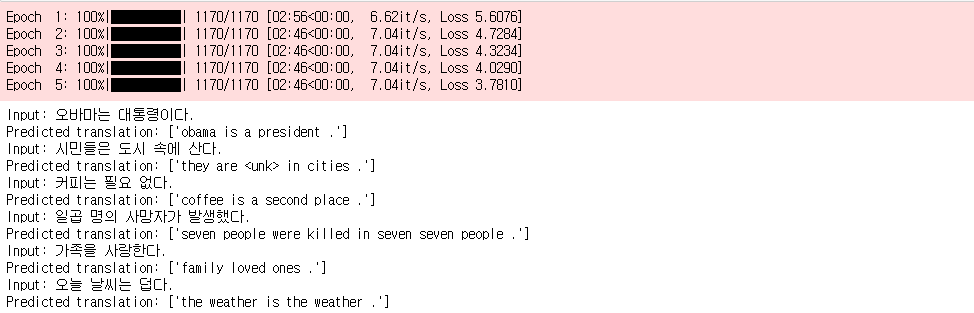

따라서 이번에는 epoch 수를 줄이고, 하이퍼 파라미터의 수를 조정하여 다시 한번 시도해보겠습니다.

# 추가 시도 2 : 에포크 수를 줄이고, 하이퍼 파라미터 변경

In [84]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [85]:
num_layers = 2
d_model = 256
num_heads = 8
d_ff = 2048
pos_len = max_len
vocab_size = 25000
drop_rate = 0.2


examples = [
    "오바마는 대통령이다.", "시민들은 도시 속에 산다.",
    "커피는 필요 없다.", "일곱 명의 사망자가 발생했다.",
    "가족을 사랑한다.","오늘 날씨는 덥다."]

transformer = Transformer(num_layers,
                    d_model,
                    num_heads,
                    d_ff,
                    vocab_size,
                    vocab_size,
                    pos_len,
                    dropout = drop_rate)

In [86]:
BATCH_SIZE = 64
EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_data.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
                    train_step(kor_data[idx:idx+BATCH_SIZE],
                                eng_data[idx:idx+BATCH_SIZE],
                                transformer,
                                optimizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    if (epoch+1) % 5 == 0:
        for example in examples:
            translate(example, transformer, kor_tokenizer, eng_tokenizer, plot_attention=False)

Epoch  5: 100%|██████████| 1170/1170 [02:22<00:00,  8.22it/s, Loss 4.0320]


Input: 오바마는 대통령이다.
Predicted translation: ['obama is the president .']
Input: 시민들은 도시 속에 산다.
Predicted translation: ['the city of the city s city .']
Input: 커피는 필요 없다.
Predicted translation: ['coffee is not a good .']
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ['the dead were killed .']
Input: 가족을 사랑한다.
Predicted translation: ['family family love']
Input: 오늘 날씨는 덥다.
Predicted translation: ['the weather is the weather .']


# 결과 비교

| Parameter  |      Model1     |      Model2     |
| ---------- | --------------- | --------------- |
| num_layers | 4               | 2               |
| d_model    | 256             | 256             |
| num_heads  | 4               | 8               |
| d_ff       | 1024            | 2048            |
| pos_len    | max_len         | max_len         |
| vocab_size | 25000           | 25000           |
| drop_rate  | 0.2             | 0.2             |
| BATCH_SIZE | 64              | 64              |
| EPOCHS     | 30              | 5               |



| Input            |   Seq2Seq+Mecab |             Transformer Model1                   |             Transformer Model2           |
| ---------------- | ------------------ |---------------------- | ----------------------------- |
| 오바마는 대통령이다.      | obama is the president . <end> |obama s campaign would begin either .    | obama is the president .      |
| 시민들은 도시 속에 산다.   | civilians are in cities , hurled high of the city . <end> |citizens show up most of <unk>           | the city of the city s city . |
| 커피는 필요 없다.       |there s no idea of the right now . <end> | at least one point , it s no .           | coffee is not a good .        |
| 일곱 명의 사망자가 발생했다. | seven dead was killed . <end> |seven soldiers were killed sunday .      | the dead were killed .        |
| 가족을 사랑한다.        |family love love of family . <end> | my family love .                         | family family love            |
| 오늘 날씨는 덥다.       | today weather has forced to today <end> |it s the weather in the city s weather . | the weather is the weather .  |
    
num_layers, num_heads, EPOCHS의 수만 바꿔서 실험을 해보았습니다.
    
앞서 예상한대로 오히려 적은 에포크일때, 좋은 번역의 성능을 보여줬습니다. 첫번째 문장인 '오바마는 대통령이다.'는 올바르게 번역한 것을 볼 수 있습니다. 또한, 'city', 'coffee', 'family' 등 주요 단어들을 제대로 번역한 것을 확인 할 수 있었습니다. 
    
또한 Seq2Seq+Mecab의 성능도 좋았습니다. 이것은 한국어에서는 sentencepiece와 같은 토크나이저보다는 mecab과 같은 한국어의 특성에 맞는 토크나이저의 성능이 더 좋다는 것을 알 수 있습니다.

# 전체 회고
- 트랜스포머는 정말 어려운것 같습니다.
- 이번 노드에서는 설명도 잘해주었지만, 트랜스포머를 제대로 알아야 이후에 나올 모델들을 제대로 이해할 수 있기에 많은 시간을 투자하였습니다.
- 개인적으로는 아직 많이 부족하다고 생각이 되며, 트랜스포머의 개념과 코드적인 이해를 위해 좀 더 시간을 할애해야 할 것으로 생각됩니다.

- 한국어는 조사라는 개념이 있기 때문에 sentencepiece같은 토크나이저보다는 mecab과 같은 한국어의 특성이 반영된 토크나이저를 쓰는것이 더 좋다고 생각이 됩니다.
- 이번 노드에서는 vocab_size를 고정하고 실험을 하였는데, 늘렸을때의 성능도 체크해보고 싶습니다.
- 하이퍼 파라미터를 조정한다면, 훨씬 더 품질이 좋은 번역이 나올 것으로 생각됩니다.

# 참고 자료
- 이전 노드
- https://wikidocs.net/31379
- https://velog.io/@nawnoes/Transformer%EB%A1%9C-%ED%95%9C%EA%B5%AD%EC%96%B4-%EC%98%81%EC%96%B4-%EB%B2%88%EC%97%AD-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EA%B8%B0
- https://wikidocs.net/166832
- https://ariz1623.tistory.com/304 